In [2]:
import numpy as np
import pandas as pd
import os
import scipy
import cv2 as cv

In [3]:
import skimage.io
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage.morphology import closing, opening, disk, square
from skimage import filters

In [44]:
import plotly.express as px
from helper import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import and plot setup data

In [5]:
path_data = 'data/image_setup/'

backs = path_data + 'back_cards.jpg'
cards = path_data + 'spades_suits.jpg'
kings = path_data + 'kings.jpg'
chips = path_data + 'chips.jpg'
paths = [backs, cards, kings, chips]

backs, cards, kings, chips = load_data(paths)
images = [backs, cards, kings, chips]

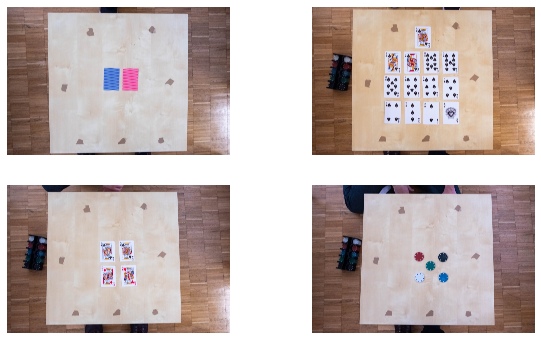

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))

for ax, image in zip(axes.flatten(), images):
    ax.imshow(image)
    ax.axis('off')
    ascii

## Cards treatment

In [9]:
print(cards.shape)

(4000, 6000, 3)


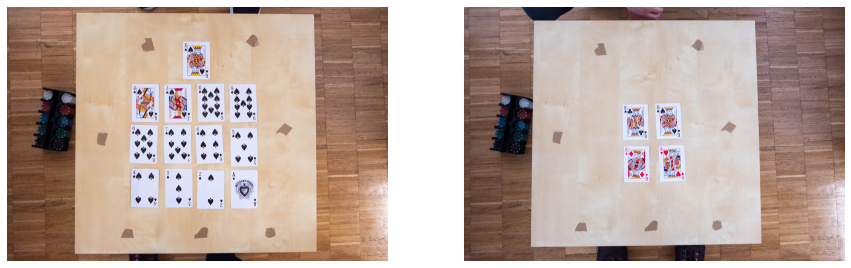

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
for image,ax in zip([cards, kings], axes):
    ax.imshow(image)
    ax.axis('off')
plt.show()

### Isolate cards, numbers and symbols (ground truth)

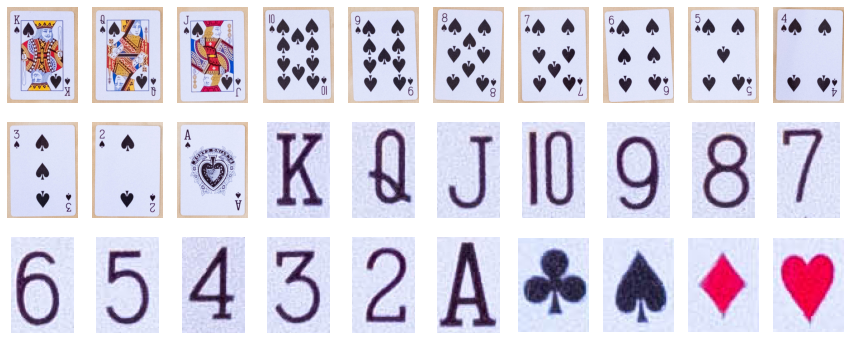

In [11]:
individual_cards, numbers, symbols = isolate_card_features(cards, kings)
all_images = individual_cards + numbers + symbols
fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(15,6))

for ax, image in zip(axes.flatten(),all_images):
    ax.imshow(image)
    ax.axis('off')
plt.show()

## Chips treatment

In [12]:
print(chips.shape)

(4000, 6000, 3)


In [13]:
def find_chips_search_area(image):
    # adapt search area to table size
    row, col = image.shape[:2]
    R, C = int(row/4), int(col/4)
    R_2 = 3*R
    C_2 = 3*C
    # return a crop on the image
    search_area = image[R:R_2, C:C_2]
    return search_area

In [14]:

_, crop = cropping_routine(chips)
chips_area = find_chips_search_area(crop)

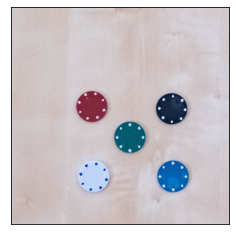

In [16]:
display_image(chips_area)

In [33]:
mask, nb = blue_mask(chips_area)

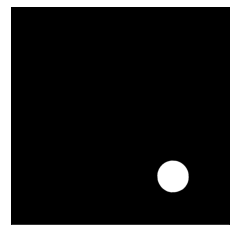

In [25]:
display_image(mask)
plt.show()

In [34]:
print(f'Number of pixels for the blue chip: {nb}')

Number of pixels for the blue chip: 50785


In [36]:
nb_red_pix  = 0 
mask_red        = np.zeros((1, 1, 1))

img_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)
# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 100, 20])
upper1 = np.array([10, 255, 255])

# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160,100,20])
upper2 = np.array([179,255,255])

lower_mask = cv.inRange(img_hsv, lower1, upper1)
upper_mask = cv.inRange(img_hsv, lower2, upper2)

full_mask_red = lower_mask + upper_mask


mask_red = cv.bitwise_and(chips_area,chips_area, mask = full_mask_red)

b = binarization(mask_red)
clos = closing(b,disk(20))
op = opening(clos,disk(20))


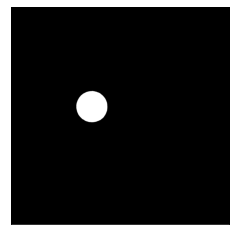

In [37]:
display_image(op)
plt.show()

In [40]:
chips_area.shape

(1750, 1760, 3)

In [39]:
nb_red_pix = np.sum(op==1)
print(f'Number of pixels for the blue chip: {nb_red_pix}')

Number of pixels for the blue chip: 49294


In [41]:
CHIPS_AREA = 50000/(1750*1760)

In [45]:
predict_blue(chips_area)

1.0

## Looking for feature detectable on train images
### Edge detector + cleaning

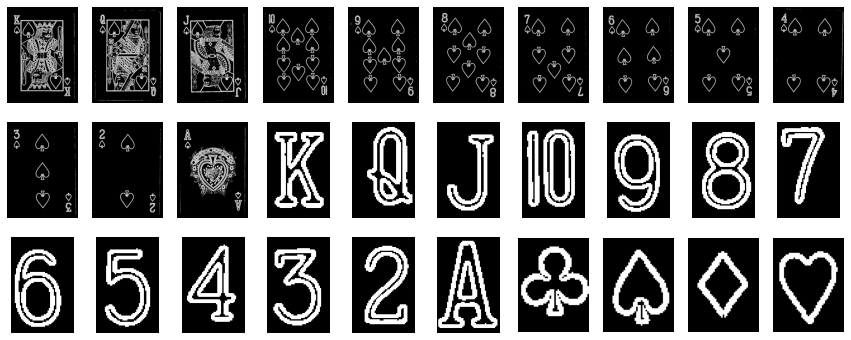

In [9]:
sobel_images = edge_detector(all_images)

fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(15,6))
for ax, image in zip(axes.flatten(), sobel_images):
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis('off')
plt.show()

### Contour detection on edge detector output
#### biggest contour per image

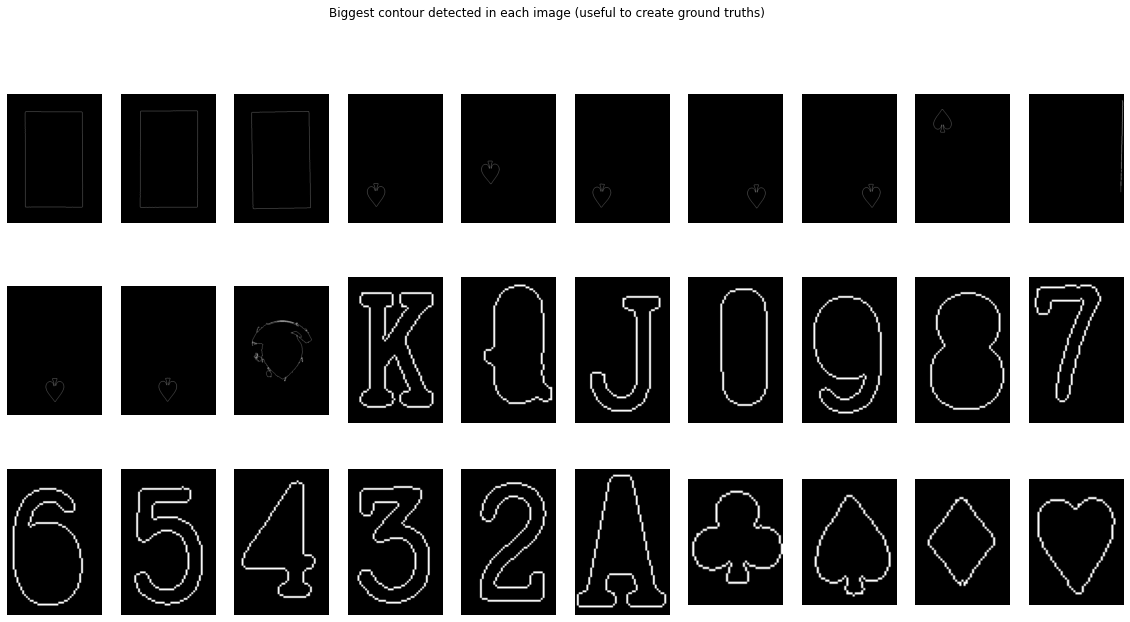

In [10]:
sobel_contours = one_contour_by_img(sobel_images)

fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(20,10))
for ax, contour, image in zip(axes.flatten(), sobel_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.axis('off')
fig.suptitle('Biggest contour detected in each image (useful to create ground truths)')
plt.show()

Note: when extracting full cards contours the biggest contour of "dressed" cards is the inner rectangle (and nothing inside is kept)

#### All contours in images

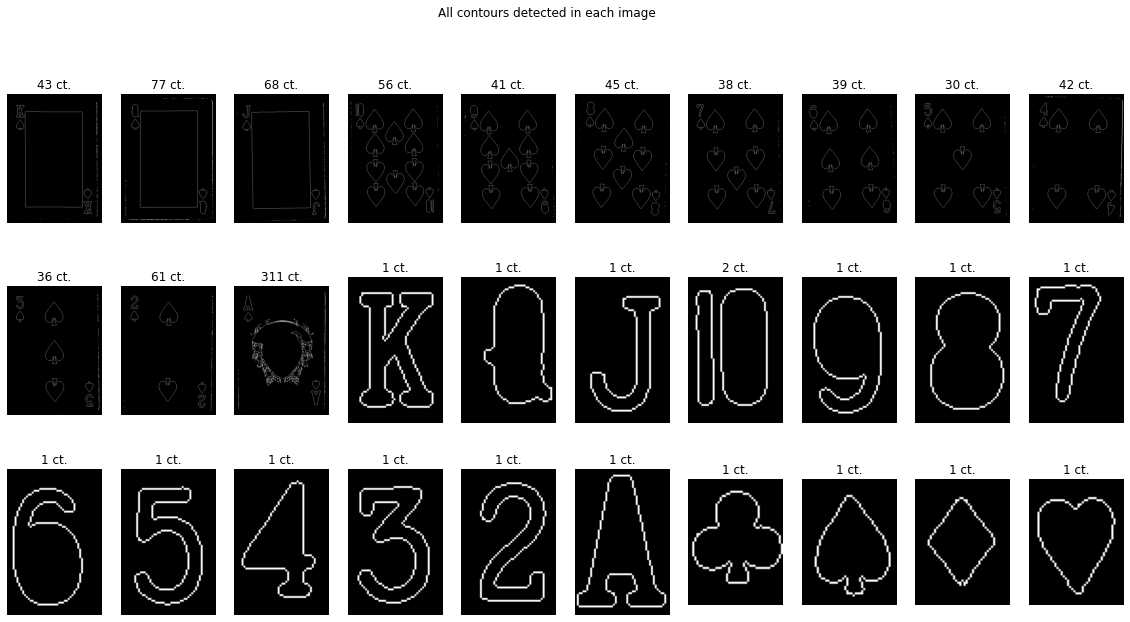

In [11]:
sobel_all_contours = contours_by_img(sobel_images)

fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(20,10))
for ax, contours, image in zip(axes.flatten(), sobel_all_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image')
plt.show()

We only find ourselves with the biggest and smallest contours (easy to clean out in theory) and symbols of interest.

#### Strategie from there: evaluate a range a contour length (tolerance because images not taken from same place each time) that we keep before making features (is it really necessary ?)

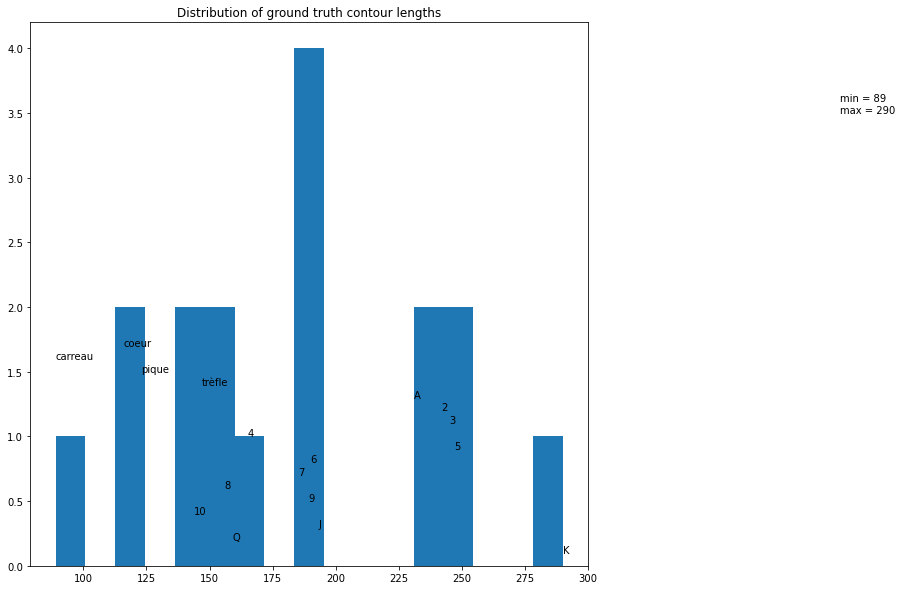

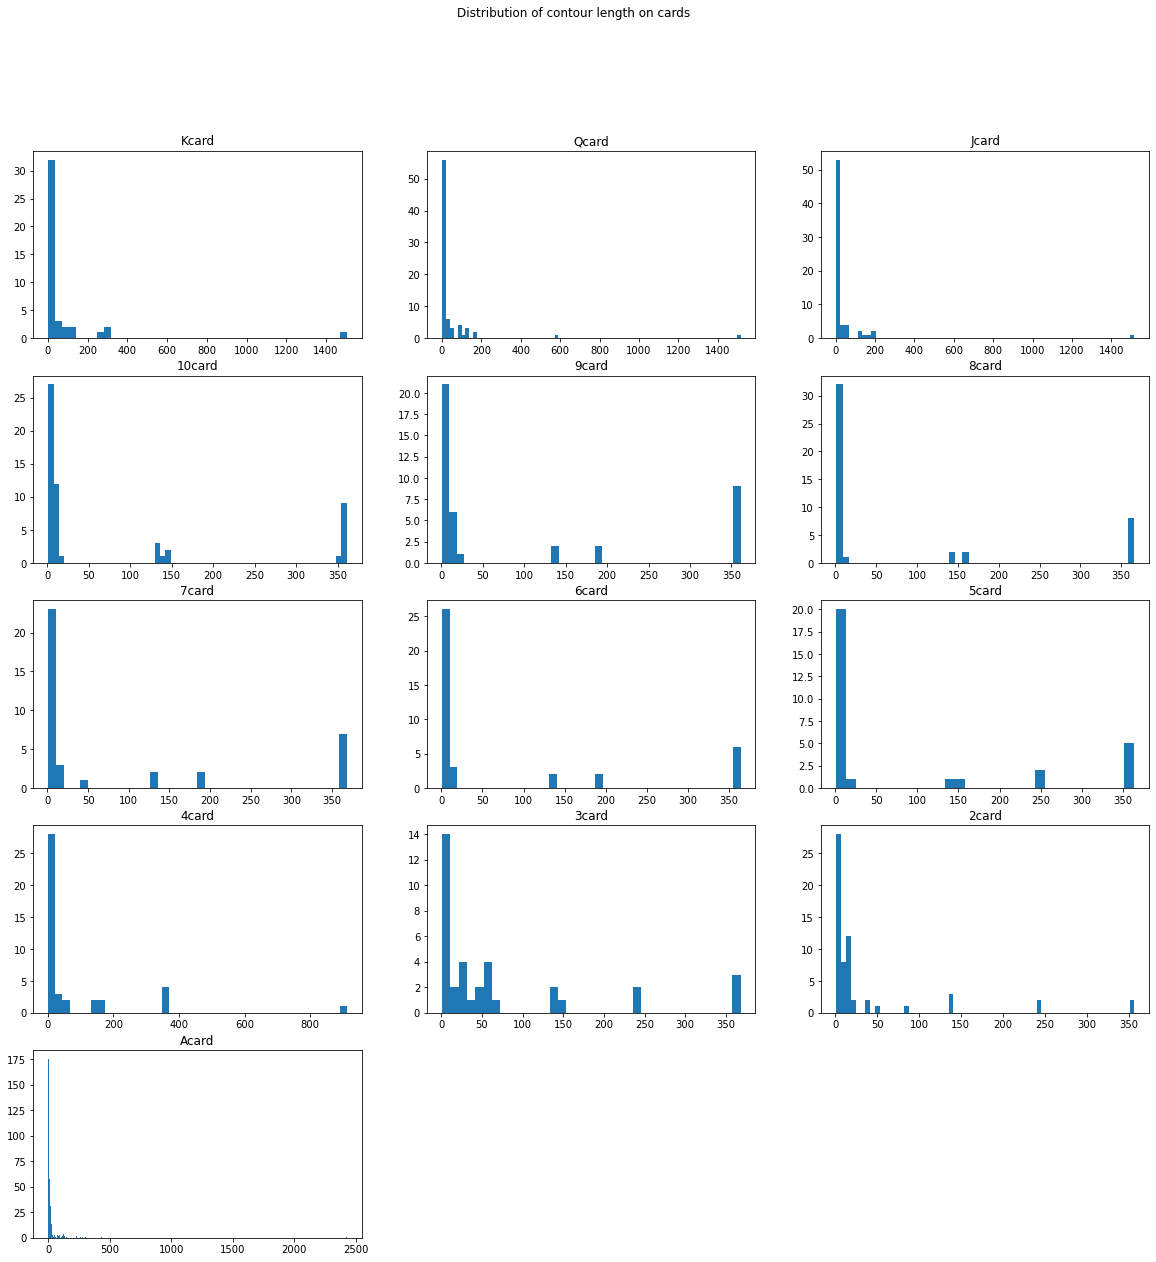

In [12]:
ground_truth_contours_len = [len(sobel_contours[i]) for i in range(13,30,1)]
cards_contours_len = sobel_all_contours[:13] 

plot_coutours_length_distrib(cards_contours_len, ground_truth_contours_len)

We notice a lot of very small contours, most likely the cards rectangle contours which are cut into very small pieces. Let's try to get rid of that.

In [13]:
min_size, max_size = np.min(ground_truth_contours_len), np.max(ground_truth_contours_len)
tol_down, tol_up = 20, 20

cont_range = [min_size-tol_down, max_size+tol_up]

lower_bound = cont_range[0]
upper_bound = cont_range[1]

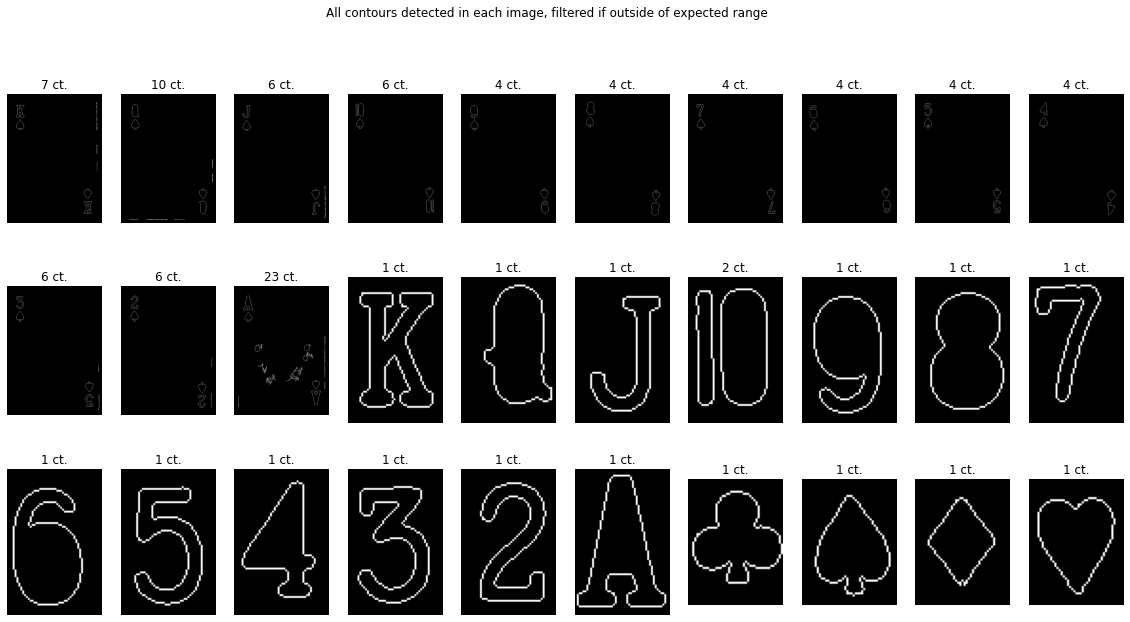

In [14]:
all_filtered_contours = filter_contours_by_size(sobel_all_contours, lower_bound, upper_bound)

fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(20,10))
for ax, contours, image in zip(axes.flatten(), all_filtered_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image, filtered if outside of expected range')
plt.show()

Note: the tolerance on size range really changes the random stuff found in the fourier field.

Except from a few artefacts of the rectangle card contours or ace shapes, there only remains shapes of interest, which we can transform into features to create ground truth features. Then, use them to recognise cards.

## Features creation

Use **ground_truth_contours** to create features and see how **cards_contours** align to those features and classified

Lets filter cards contours to avoid problems with fourier descriptor computation.

In [15]:
cards_contours = all_filtered_contours[:13]
ground_truth_contours = [sobel_contours[i] for i in range(13,30,1)]

Not use 1st descriptor f0 (affected by translation)

Use ratio of f1,f2,f3,f4 (otherwise not invariant to scaling) necessary? Because worst predictors than without that

Compute Fourier descriptors

In [16]:
n = 10
# compute ground truth descriptors
GT_descr = n_FT_descr(complex_contours(ground_truth_contours), n)

# compute all filtered cards contours descriptors
cards_comp_ct = [complex_contours(card_cont) for card_cont in cards_contours]
cards_descr = [n_FT_descr(comp_ct, n) for comp_ct in cards_comp_ct]

Manipulate descriptors for invariance.

cards_3D_descr is a list of K x n array descriptors (K contours, n descr per contour)
GT_3D_descr is a 17 x 3 array descriptors (17 ground truths possible)

## try to acount for scaling by taking ratios

In [17]:
# cards_3D_descr = []
# for card_descr in cards_descr:
#     descr_1 = card_descr[:,1]/card_descr[:,3]
#     descr_2 = card_descr[:,2]/card_descr[:,4]
#     descr_3 = card_descr[:,5]/card_descr[:,7]
#     descr_4 = card_descr[:,6]/card_descr[:,8]
#     descr_5 = card_descr[:,9]/card_descr[:,10]
#     card_contours_descr = np.vstack([descr_1,descr_2,descr_3,descr_4,descr_5]).T
#     cards_3D_descr.append(card_contours_descr)
    
# descr_1 = GT_descr[:,1]/GT_descr[:,3]
# descr_2 = GT_descr[:,2]/GT_descr[:,4]
# descr_3 = GT_descr[:,5]/GT_descr[:,7]
# descr_4 = GT_descr[:,6]/GT_descr[:,8]
# descr_5 = GT_descr[:,9]/GT_descr[:,10]

# GT_3D_descr = np.vstack([descr_1,descr_2,descr_3,descr_4,descr_5]).T

# print(len(cards_3D_descr), cards_3D_descr[0].shape)
# print(GT_3D_descr.shape)

## Not accounting for scaling

In [18]:
cards_3D_descr = []
for card_descr in cards_descr:
    descr_1 = card_descr[:,1]
    descr_2 = card_descr[:,2]
    descr_3 = card_descr[:,3]
    descr_4 = card_descr[:,4]
    descr_5 = card_descr[:,5]
    descr_6 = card_descr[:,6]
    descr_7 = card_descr[:,7]
    descr_8 = card_descr[:,8]
    descr_9 = card_descr[:,9]
    card_contours_descr = np.vstack([descr_1,descr_2,descr_3,
                                     descr_4,descr_5,descr_6,
                                    descr_7,descr_8,descr_9]).T
    cards_3D_descr.append(card_contours_descr)
    
    descr_1 = GT_descr[:,1]
    descr_2 = GT_descr[:,2]
    descr_3 = GT_descr[:,3]
    descr_4 = GT_descr[:,4]
    descr_5 = GT_descr[:,5]
    descr_6 = GT_descr[:,6]
    descr_7 = GT_descr[:,7]
    descr_8 = GT_descr[:,8]
    descr_9 = GT_descr[:,9]

GT_3D_descr = np.vstack([descr_1,descr_2,descr_3,
                         descr_4,descr_5,descr_6,
                        descr_7,descr_8,descr_9]).T

print(len(cards_3D_descr), cards_3D_descr[0].shape)
print(GT_3D_descr.shape)

13 (7, 9)
(17, 9)


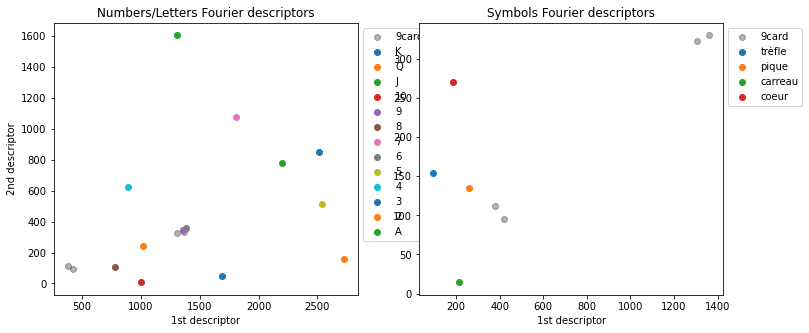

In [19]:
plot_fourier_descr_and_card_contours(GT_3D_descr, cards_3D_descr, card_idx = 4)

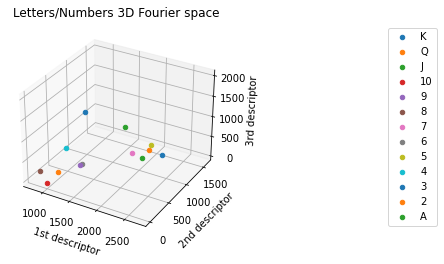

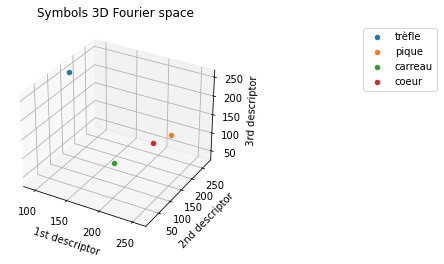

In [20]:
plot_fourier_descr_3D(GT_3D_descr)

In [21]:
#GT_df = pd.DataFrame(GT_3D_descr, columns = ['descr 1', 'descr 2', 'descr 3'], index = ground_truth_titles)
GT_df = pd.DataFrame(GT_3D_descr, columns = ['descr 1', 'descr 2', 'descr 3', 'descr 4', 'descr 5', 'descr 6', 'descr 7', 'descr 8', 'descr 9'], index = ground_truth_titles)
print(GT_df)

             descr 1      descr 2      descr 3     descr 4     descr 5  \
K        1689.707998     48.14595  1990.822826  289.558142  211.095867   
Q        1017.369468   240.422667   117.684779   87.081974  113.547122   
J        2198.860202   779.443913   484.243535  156.859148  198.821952   
10         998.68302      6.60493     40.72835     4.72198   14.123254   
9        1360.587478   345.339772    351.62012  262.008972  182.357158   
8         778.552031   108.658165   155.216965   65.651352   68.664099   
7        1808.050269  1076.408277   194.452635   115.09517  185.695203   
6        1378.906077   360.805451   358.785961  264.413288  191.777985   
5        2534.319071   511.498873   1158.66146  408.294019  549.922136   
4         890.812888   621.829502   330.396348   90.705618    88.15994   
3        2508.981126   852.891653   632.373608  605.932315  617.804328   
2        2727.110744   156.384032  1432.025707  132.723551  511.695019   
A        1303.407096  1605.067863   22

9 AND 6 HAVE OBVIOUSLY SIMILAR FOURIER DESCRIPTOR => NEED TO FIND A NON-FOURIER DESCRIPTOR TO DIFFERENTIATE THEM

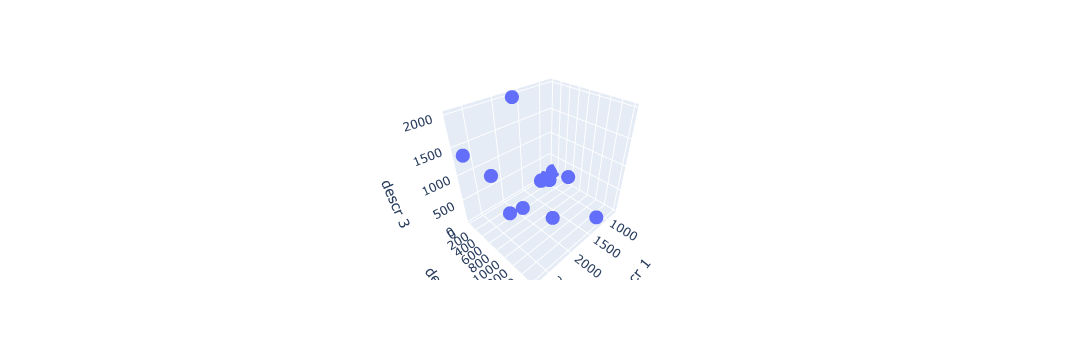

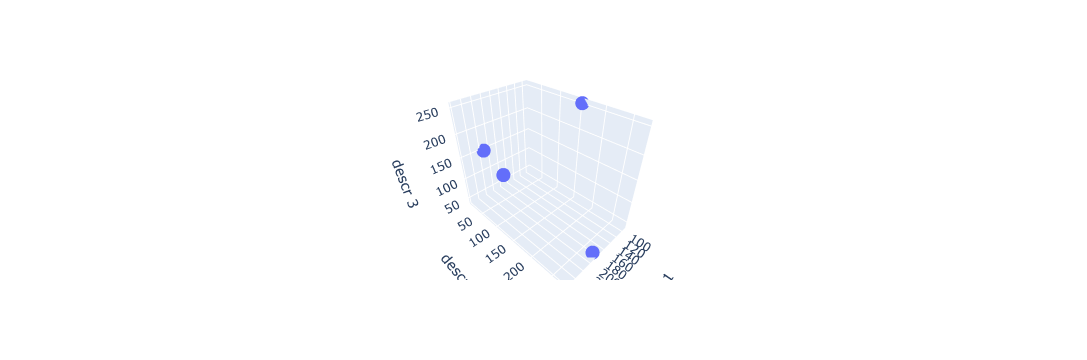

In [22]:
plot_interactive_3D_descr(GT_df)

In [23]:
number_key = {0 : 'K', 1 : 'Q', 2 : 'J', 3 : '10', 4 : '9',
            5 : '8', 6 : '7', 7 : '6', 8 : '5', 9 : '4',
            10 : '3', 11 : '2', 12 : 'A'}
symbol_key = {0 : 'trèfle', 1 : 'pique', 2 : 'carreau', 3 : 'coeur'}

pred_numbers, pred_symbols = predict_cards_from_predictors(cards_3D_descr, GT_3D_descr, number_key, symbol_key)

In [24]:
print(f'Expected number/letter: {ground_truth_titles[:-4]}')
print(f'Predicted number/letter: {pred_numbers}')
print('\n')
print(f'Expected symbol: only pique')
print(f'Predicted symbol: {pred_symbols}')

Expected number/letter: ['K', 'Q', 'J', '10', '9', '8', '7', '6', '5', '4', '3', '2', 'A']
Predicted number/letter: ['K', 'Q', 'J', '10', '9', '8', '7', '6', '5', '4', '3', '2', 'A']


Expected symbol: only pique
Predicted symbol: ['pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique']


stable ? we dont account for scaling here

## Trial on random image

In [25]:
test_img = 'data/train/train_00.jpg'
test_img = load_data([test_img])[0]

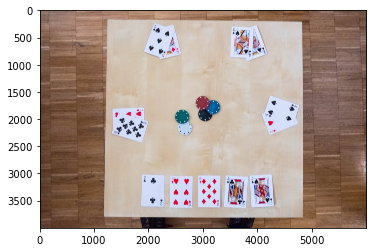

In [26]:
plt.imshow(test_img)
plt.show()

In [27]:
def plot_card(idx, idy, r, c):
    fig, axes = plt.subplots(ncols=5, figsize=(10,6))
    for ax,x,y in zip(axes.flatten(),idx, idy):
        ax.imshow(test_img[x:x+r,y:y+c])
        ax.axis('off')
    plt.show()

In [28]:
idx = [3000,3020,3000,3020,3000]
row = 640
idy = [1840,2360,2860,3360,3840]
col = 470

test_cards = []
for x,y in zip(idx, idy):
    card = test_img[x:x+row, y:y+col]
    test_cards.append(card)

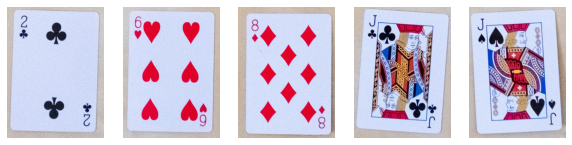

In [29]:
#plot_card(idx,idy,row,col)

fig, axes = plt.subplots(ncols = 5, figsize=(10,6))

for ax, image in zip(axes.flatten(),test_cards):
    ax.imshow(image)
    ax.axis('off')
plt.show()

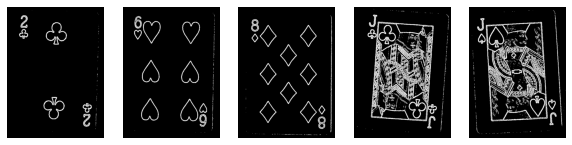

In [30]:
sobel_test_images = edge_detector(test_cards)

fig, axes = plt.subplots(ncols = 5, nrows = 1, figsize=(10,6))
for ax, image in zip(axes.flatten(), sobel_test_images):
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis('off')
plt.show()

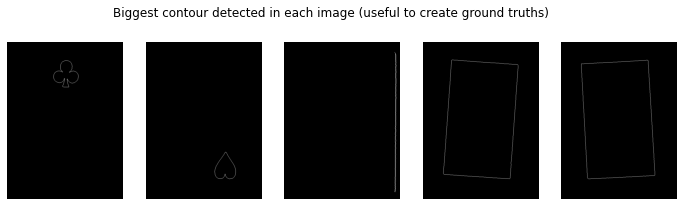

In [31]:
test_contours = one_contour_by_img(sobel_test_images)

fig, axes = plt.subplots(ncols = 5, figsize=(12,8))
for ax, contour, image in zip(axes.flatten(), test_contours, test_cards):
    im = np.zeros((image.shape[0], image.shape[1]))
    im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.axis('off')
fig.suptitle('Biggest contour detected in each image (useful to create ground truths)', y = 0.7)
plt.show()

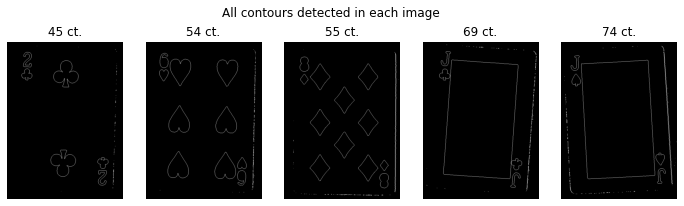

In [32]:
test_all_contours = contours_by_img(sobel_test_images)

fig, axes = plt.subplots(ncols = 5, figsize=(12,8))
for ax, contours, image in zip(axes.flatten(), test_all_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image', y = 0.7)
plt.show()

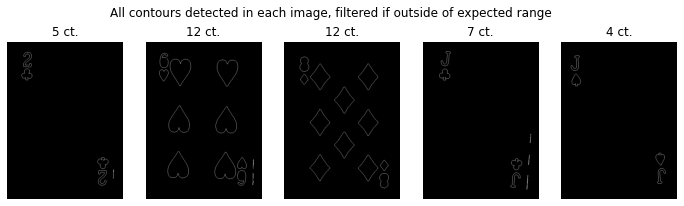

In [33]:
test_filtered_contours = filter_contours_by_size(test_all_contours, lower_bound, upper_bound)

fig, axes = plt.subplots(ncols = 5, figsize=(12,8))
for ax, contours, image in zip(axes.flatten(), test_filtered_contours, test_cards):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image, filtered if outside of expected range', y = 0.7)
plt.show()

In [34]:
cards_comp_ct = [complex_contours(card_cont) for card_cont in test_filtered_contours]
test_descr = [n_FT_descr(comp_ct, n) for comp_ct in cards_comp_ct]

In [35]:
test_3D_descr = []
for card_descr in test_descr:
    descr_1 = card_descr[:,1]
    descr_2 = card_descr[:,2]
    descr_3 = card_descr[:,3]
    descr_4 = card_descr[:,4]
    descr_5 = card_descr[:,5]
    descr_6 = card_descr[:,6]
    descr_7 = card_descr[:,7]
    descr_8 = card_descr[:,8]
    descr_9 = card_descr[:,9]
    card_contours_descr = np.vstack([descr_1,descr_2,descr_3,
                                     descr_4,descr_5,descr_6,
                                    descr_7,descr_8,descr_9]).T
    test_3D_descr.append(card_contours_descr)

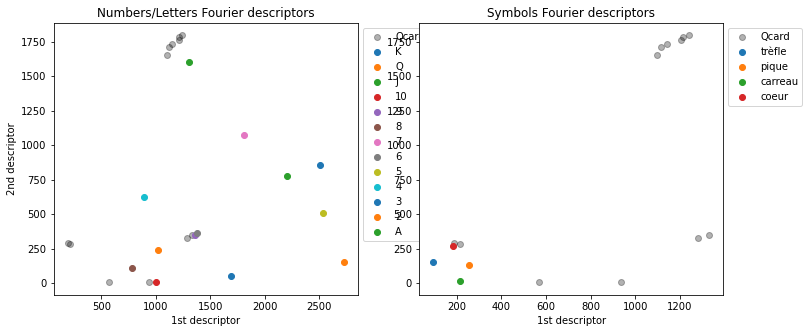

In [36]:
plot_fourier_descr_and_card_contours(GT_3D_descr, test_3D_descr, card_idx = 1)

In [37]:
number_key = {0 : 'K', 1 : 'Q', 2 : 'J', 3 : '10', 4 : '9',
            5 : '8', 6 : '7', 7 : '6', 8 : '5', 9 : '4',
            10 : '3', 11 : '2', 12 : 'A'}
symbol_key = {0 : 'trèfle', 1 : 'pique', 2 : 'carreau', 3 : 'coeur'}

pred_numbers, pred_symbols = predict_cards_from_predictors(test_3D_descr, GT_3D_descr, number_key, symbol_key)

In [38]:
print(f'Expected number/letter: [2,   6,   8,   J,   J]')
print(f'Predicted number/letter: {pred_numbers}')
print('\n')
print(f'Expected symbol: [trèfle,   coeur,   carreau,   trèfle,   pique]')
print(f'Predicted symbol: {pred_symbols}')

Expected number/letter: [2,   6,   8,   J,   J]
Predicted number/letter: ['2', '9', '8', 'J', 'J']


Expected symbol: [trèfle,   coeur,   carreau,   trèfle,   pique]
Predicted symbol: ['trèfle', 'coeur', 'carreau', 'trèfle', 'pique']
